In [2]:
%pylab inline
%run ../../figures/params.py

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import pandas as pd
import os
import numpy as np
import sklearn.model_selection as xval
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.ensemble import RandomForestRegressor
import scipy.stats

MAXLEN = 20

features = ['uninterrupted_length','p2', 'p4']

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Load parameters
params = {}
with open("params.sh", "r") as f:
    for line in f:
        if "=" not in line: continue
        key, val = line.strip().split("=")
        params[key] = val

In [3]:
#params["BASEDIR"] = "/Users/gymrek/workspace/mutea-autosomal/analyses/data/" #"~/Downloads"
#params["PREDFILE"] = os.path.join("/Users/gymrek/Downloads/", "constraint","autosomal_perlocus_estimates.bed")
#params["PREDFILE"] = os.path.join("/Users/gymrek/workspace/mutea-autosomal/analyses/data/constraint/autosomal_perlocus_estimates.bed")

In [15]:
def CenterData(data):
    df = pd.DataFrame({"data": data, "ind": range(data.shape[0])})
    df = df.sort("data")
    vals = np.random.normal(size=data.shape[0])
    vals = sorted(vals)
    df["norm"] = vals
    df = df.sort("ind")
    return df["norm"]

def SetFilterModel1(df, colname="filter"):
    #df[colname] = False
    #df.ix[(df["ml_mu_stderr_adj"]<=0) | (df["ml_mu_stderr_adj"]>=0.10), colname] = True # doesn't work in new pandas
    df[colname] = df.apply(lambda x: (x["ml_mu_stderr_adj"]<=0) or (x["ml_mu_stderr_adj"]>=0.1) ,1)
    
def SetFilterModel2(df, colname="filter"):
    df[colname] = False
    #df.ix[(df["ml_mu_stderr_adj"]<0), colname] = True

In [6]:
params["BASEDIR"] = "../../data/" #"~/Downloads"
params["PREDFILE"] = "../../data/autosomal_perlocus_estimates.bed"

In [20]:
datafile = os.path.join(params["BASEDIR"], "autosomal_perlocus_train_intergenic.bed.gz")
dataset = pd.read_csv(datafile, sep="\t").drop_duplicates()
dataset["ml_mu_stderr_adj"] = dataset.apply(lambda x: x["ml_mu_stderr"]/abs(x["ml_mu"]), 1)

# Remove stderr=0
dataset = dataset[dataset["ml_mu_stderr_adj"]!=0]

# Set new features
dataset['period'] = dataset['motif'].str.len()
dataset["pbyl"] = dataset.apply(lambda x: x["uninterrupted_length"]*1.0/x["period"], 1)
dataset['p2'] = (dataset["period"]==2).apply(int)
dataset['p4'] = (dataset["period"]==4).apply(int)

# Restrict to di, tri, tetra, longer
dataset = dataset[dataset["period"].apply(lambda x: x in [2,3,4])]
dataset = dataset[~dataset["featurefilter"]]
dataset = dataset[dataset["length"]>=MAXLEN]

0.47631720845396686
(0.8065244056205724, 0.0)
21122
(0.6769529559860065, 0.0)
5639


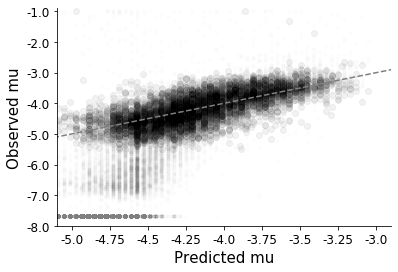

In [22]:
##################
# Linear Regression - Model 1
##################

filtercolor = "gray"
keepcolor = "black"

# Set filter field
SetFilterModel1(dataset, colname="filter1")

# Center data (not length and period)
#for f in ["gc","entropy","recomb","reptiming"]:
#    dataset[f] = CenterData(dataset[f])

# Split data to train and test
base_X = dataset[features] #pd.get_dummies(dataset[features], prefix="motif")
base_y = dataset['ml_mu']
base_filter = dataset["filter1"]
base_weights = dataset["ml_mu_stderr_adj"].apply(lambda x: 1.0/(x**2))
train_X, test_X, \
    train_y, test_y, \
    train_filter, test_filter, \
    train_weights, test_weights = xval.train_test_split(base_X, base_y, base_filter, base_weights, test_size=0.25)
y_colors = test_filter.apply(lambda x: [keepcolor, filtercolor][int(x)])

# Filter training data
train_X = train_X[~train_filter]
train_y = train_y[~train_filter]
train_weights = train_weights[~train_filter]

# Build linear regression model
train_X_sm = sm.add_constant(train_X)
model1 = sm.OLS(train_y, train_X_sm)
smols1 = model1.fit()
pred_y = smols1.predict(sm.add_constant(test_X))

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pred_y[y_colors.values==filtercolor], test_y[y_colors.values==filtercolor], alpha=0.01, color=filtercolor, s=10)
ax.scatter(pred_y[y_colors.values==keepcolor], test_y[y_colors.values==keepcolor], alpha=0.05, color=keepcolor)
plt.plot([-7, -2],[-7,-2], color="gray", linestyle="dashed")
ax.set_xlim(left=-5.1, right=-2.9)
ax.set_ylim(bottom=-8, top=-0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted mu", size=15)
ax.set_ylabel("Observed mu", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)

print(smols1.rsquared_adj)
print(pearsonr(pred_y, test_y))
print(len(pred_y))
print(pearsonr(pred_y[~test_filter.values], test_y[~test_filter.values]))
print(len(pred_y[~test_filter.values]))

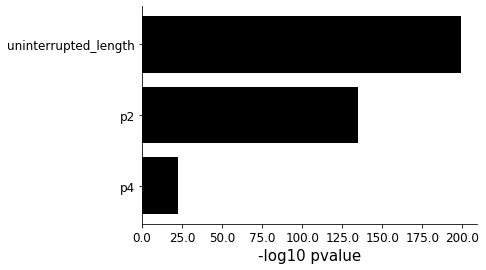

In [24]:
mparams = pd.DataFrame({"feature": smols1.params.index, "coeff": smols1.params, "pval": smols1.pvalues})
mparams["log10p"] = -1*np.log10(mparams["pval"]+10e-200)
mparams = mparams[mparams["feature"] != "const"]
mparams = mparams.sort_values("pval", ascending=False)
ind = range(1, mparams.shape[0]+1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.barh(ind, mparams["log10p"], align="center", color="black")
ax.set_yticks(ind);
ax.set_yticklabels(mparams.feature);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("-log10 pvalue", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticklabels(), size=12);
#fig.savefig(os.path.join("../../figures/", PLOTDIR, "Figure3_modelparams.pdf"))

0.6513914860905793
(0.8072546277375637, 0.0)
(0.8072546277375637, 0.0)


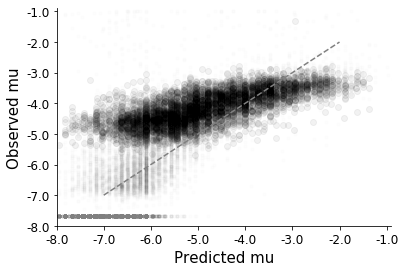

In [26]:
##################
# Linear Regression - Model 2
##################

filtercolor = "gray"
keepcolor = "black"

# Set filter field
SetFilterModel2(dataset, colname="filter2")

# Center data (not length and period)
#for f in ["gc","entropy","recomb","reptiming"]:
#    dataset[f] = CenterData(dataset[f])

# Split data to train and test
base_X = dataset[features] #pd.get_dummies(dataset[features], prefix="motif")
base_y = dataset['ml_mu']
base_filter = dataset["filter2"]
base_filter1 = dataset["filter1"]
base_weights = dataset["ml_mu_stderr_adj"].apply(lambda x: 1.0/(x**2))
train_X, test_X, \
    train_y, test_y, \
    train_filter, test_filter, \
    train_filter1, test_filter1, \
    train_weights, test_weights = xval.train_test_split(base_X, base_y, base_filter, base_filter1, base_weights, test_size=0.25)
y_colors = test_filter1.apply(lambda x: [keepcolor, filtercolor][int(x)])

# Filter training data
train_X = train_X[~train_filter]
train_y = train_y[~train_filter]
train_weights = train_weights[~train_filter]

# Build linear regression model
train_X_sm = sm.add_constant(train_X)
model2 = sm.OLS(train_y, train_X_sm)
smols2 = model2.fit()
pred_y = smols2.predict(sm.add_constant(test_X))

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pred_y[y_colors.values==filtercolor], test_y[y_colors.values==filtercolor], alpha=0.01, color=filtercolor, s=10)
ax.scatter(pred_y[y_colors.values==keepcolor], test_y[y_colors.values==keepcolor], alpha=0.05, color=keepcolor)
plt.plot([-7, -2],[-7,-2], color="gray", linestyle="dashed")
ax.set_xlim(left=-8, right=-0.9)
ax.set_ylim(bottom=-8, top=-0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted mu", size=15)
ax.set_ylabel("Observed mu", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
#fig.savefig(os.path.join("../../figures/", PLOTDIR, "Figure3_modeleval.png"))

print(smols2.rsquared_adj)
print(pearsonr(pred_y, test_y))
print(pearsonr(pred_y[~test_filter.values], test_y[~test_filter.values]))

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>
(0.75172917307074, 0.0)
(0.7042905662812879, 0.0)


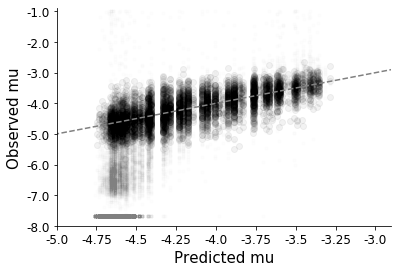

In [27]:
##################
# Random Forest - Model 3
##################

filtercolor = "gray"
keepcolor = "black"

# Center data (not length and period)
#for f in ["gc","entropy","recomb","reptiming"]:
#    dataset[f] = CenterData(dataset[f])

# Split data to train and test
base_X = dataset[features] #pd.get_dummies(dataset[features], prefix="motif")
base_y = dataset['ml_mu']
base_filter = dataset["filter1"]
base_filter1 = dataset["filter1"]
base_weights = dataset["ml_mu_stderr_adj"].apply(lambda x: 1.0/(x**2))
train_X, test_X, \
    train_y, test_y, \
    train_filter, test_filter, \
    train_filter1, test_filter1, \
    train_weights, test_weights = xval.train_test_split(base_X, base_y, base_filter, base_filter1, base_weights, test_size=0.25)
y_colors = test_filter1.apply(lambda x: [keepcolor, filtercolor][int(x)])

# Filter training data
train_X = train_X[~train_filter]
train_y = train_y[~train_filter]
train_weights = train_weights[~train_filter]

# Build linear regression model
model3 = RandomForestRegressor(min_samples_leaf=10)
model3.fit(train_X, train_y)
pred_y = model3.predict(test_X)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pred_y[y_colors.values==filtercolor], test_y[y_colors.values==filtercolor], alpha=0.01, color=filtercolor, s=10)
ax.scatter(pred_y[y_colors.values==keepcolor], test_y[y_colors.values==keepcolor], alpha=0.05, color=keepcolor)
plt.plot([-7, -2],[-7,-2], color="gray", linestyle="dashed")
ax.set_xlim(left=-5, right=-2.9)
ax.set_ylim(bottom=-8, top=-0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted mu", size=15)
ax.set_ylabel("Observed mu", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
#fig.savefig(os.path.join("../../figures/", PLOTDIR, "Figure3_modeleval.png"))

print(model3.score)
print(pearsonr(pred_y, test_y))
print(pearsonr(pred_y[~test_filter.values], test_y[~test_filter.values]))

In [ ]:
##################
# Predict
##################

# Load data
datafile = os.path.join(params["BASEDIR"], "autosomal_perlocus_observed.bed.gz")
dataset = pd.read_csv(datafile, sep="\t").drop_duplicates()

# Load extra features
dataset["period"] = dataset["motif"].apply(len)
dataset["pbyl"] = dataset.apply(lambda x: x["uninterrupted_length"]*1.0/x["period"], 1)
dataset['p2'] = (dataset["period"]==2).apply(int)
dataset['p4'] = (dataset["period"]==4).apply(int)
dataset["ml_mu_stderr_adj"] = dataset.apply(lambda x: x["ml_mu_stderr"]/abs(x["ml_mu"]), 1)

# Filter
dataset = dataset[dataset["period"].apply(lambda x: x in [2,3,4])]
dataset = dataset[dataset["length"]>=MAXLEN]
SetFilterModel1(dataset, colname="filter1")
SetFilterModel2(dataset, colname="filter2")

# Predict and save
dataset['pred_mu_1'] = smols1.predict(sm.add_constant(dataset[features]))
dataset['pred_mu_se_1'] = wls_prediction_std(smols1, sm.add_constant(dataset[features]))[0]
dataset['pred_mu_2'] = smols2.predict(sm.add_constant(dataset[features]))
dataset['pred_mu_se_2'] = wls_prediction_std(smols2, sm.add_constant(dataset[features]))[0]
dataset['pred_mu_3'] = model3.predict((dataset[features]))

# Analyze zscores
def GetZscore(x, prefix=""):
    num = x["ml_mu"] - x["pred_mu%s"%prefix]
    se = x["ml_mu_stderr"]
    if se < 0: se = 0
    denom = np.sqrt(se**2/2 + x["pred_mu_se%s"%prefix]**2/2)
    return num/denom

dataset["zscore_1"] = dataset.apply(lambda x: GetZscore(x, "_1"), 1)
dataset["zscore_2"] = dataset.apply(lambda x: GetZscore(x, "_2"), 1)
dataset["diff_1"] = dataset["ml_mu"] - dataset["pred_mu_1"]
dataset["diff_2"] = dataset["ml_mu"] - dataset["pred_mu_2"]
dataset["diff_3"] = dataset["ml_mu"] - dataset["pred_mu_3"]

header = ['chrom','start','end','ml_mu','ml_mu_stderr','motif', "uninterrupted_length", \
          'pred_mu_1','pred_mu_se_1', 'pred_mu_2', 'pred_mu_se_2', 'pred_mu_3', 'filter1','filter2',\
         'zscore_1','zscore_2','diff_1','diff_2','diff_3']
dataset[header].to_csv(params["PREDFILE"], columns=header, index=False)

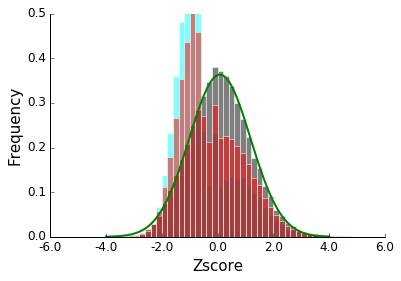

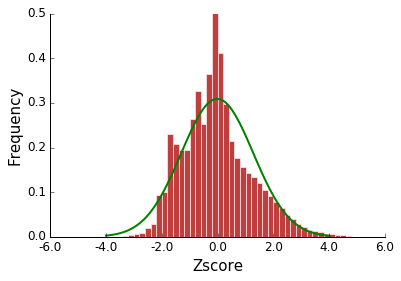

In [46]:
for i in [1, 2]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bins = np.arange(-5, 5, 0.2)
    ax.hist(dataset[dataset["filter%s"%i]]["zscore_%s"%i], bins=bins, edgecolor="white", color="cyan", normed=True, alpha=0.5);
    ax.hist(dataset[~dataset["filter%s"%i]]["zscore_%s"%i], bins=bins, edgecolor="white", color="black", normed=True, alpha=0.5);
    ax.hist(dataset["zscore_%s"%i], bins=bins, edgecolor="white", color="red", normed=True, alpha=0.5);
    ax.set_ylim(bottom=0, top=0.5)

    # Fit normal - unfiltered
    mu = np.mean(dataset[~dataset["filter%s"%i]]["zscore_%s"%i])
    std = np.sqrt(np.var(dataset[~dataset["filter%s"%i]]["zscore_%s"%i]))
    xvals = np.linspace(-4, 4, 100)
    p = scipy.stats.norm.pdf(xvals, mu, std)
    ax.plot(xvals, p, linewidth=2, color="green")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel("Zscore", size=15)
    ax.set_ylabel("Frequency", size=15)
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12);

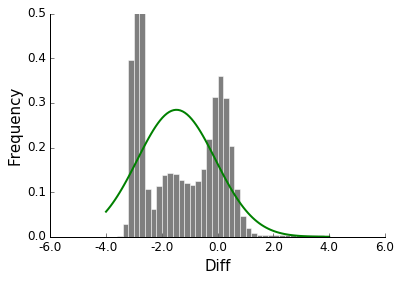

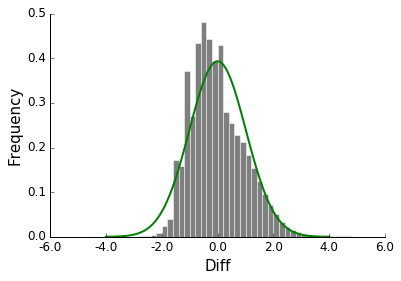

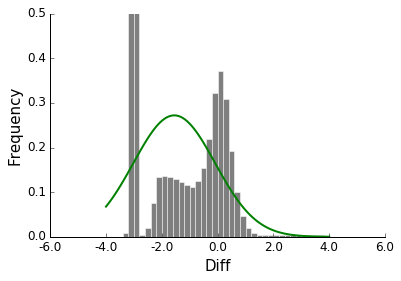

In [47]:
for i in [1, 2, 3]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bins = np.arange(-5, 5, 0.2)
    ax.hist(dataset["diff_%s"%i], bins=bins, edgecolor="white", color="black", normed=True, alpha=0.5);
    ax.set_ylim(bottom=0, top=0.5)

    # Fit normal - unfiltered
    mu = np.mean(dataset["diff_%s"%i])
    std = np.sqrt(np.var(dataset["diff_%s"%i]))
    xvals = np.linspace(-4, 4, 100)
    p = scipy.stats.norm.pdf(xvals, mu, std)
    ax.plot(xvals, p, linewidth=2, color="green")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel("Diff", size=15)
    ax.set_ylabel("Frequency", size=15)
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12);